---
title: Spectrum - Phase Correction
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

Phase correction is a crucial frequency-domain operation applied after the Fourier Transform.
Due to hardware delays, filter group delays, and off-resonance effects, the real part of
the resulting complex spectrum often contains a mixture of absorptive and dispersive
lineshapes, rather than pure absorptive peaks.

A phase correction applies a frequency-dependent phase angle, $\phi(\omega)$, to the spectrum:

$$S_{phased}(\omega) = S(\omega) \cdot e^{i \cdot \phi(\omega)}$$

Where the phase angle is typically modeled as a linear polynomial consisting of a zero-order
(frequency-independent) term $p_0$ and a first-order (frequency-dependent) term $p_1$:

$$\phi(\omega) = p_0 + p_1 \cdot \frac{\omega}{\omega_{max}}$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Ensure the accessor is registered
import xmris


## 1. Generating Synthetic Unphased Data

Let's generate a synthetic, noisy Free Induction Decay (FID) with two distinct peaks,
convert it to a spectrum, and then intentionally apply severe zero- and first-order
phase errors to simulate raw scanner data.

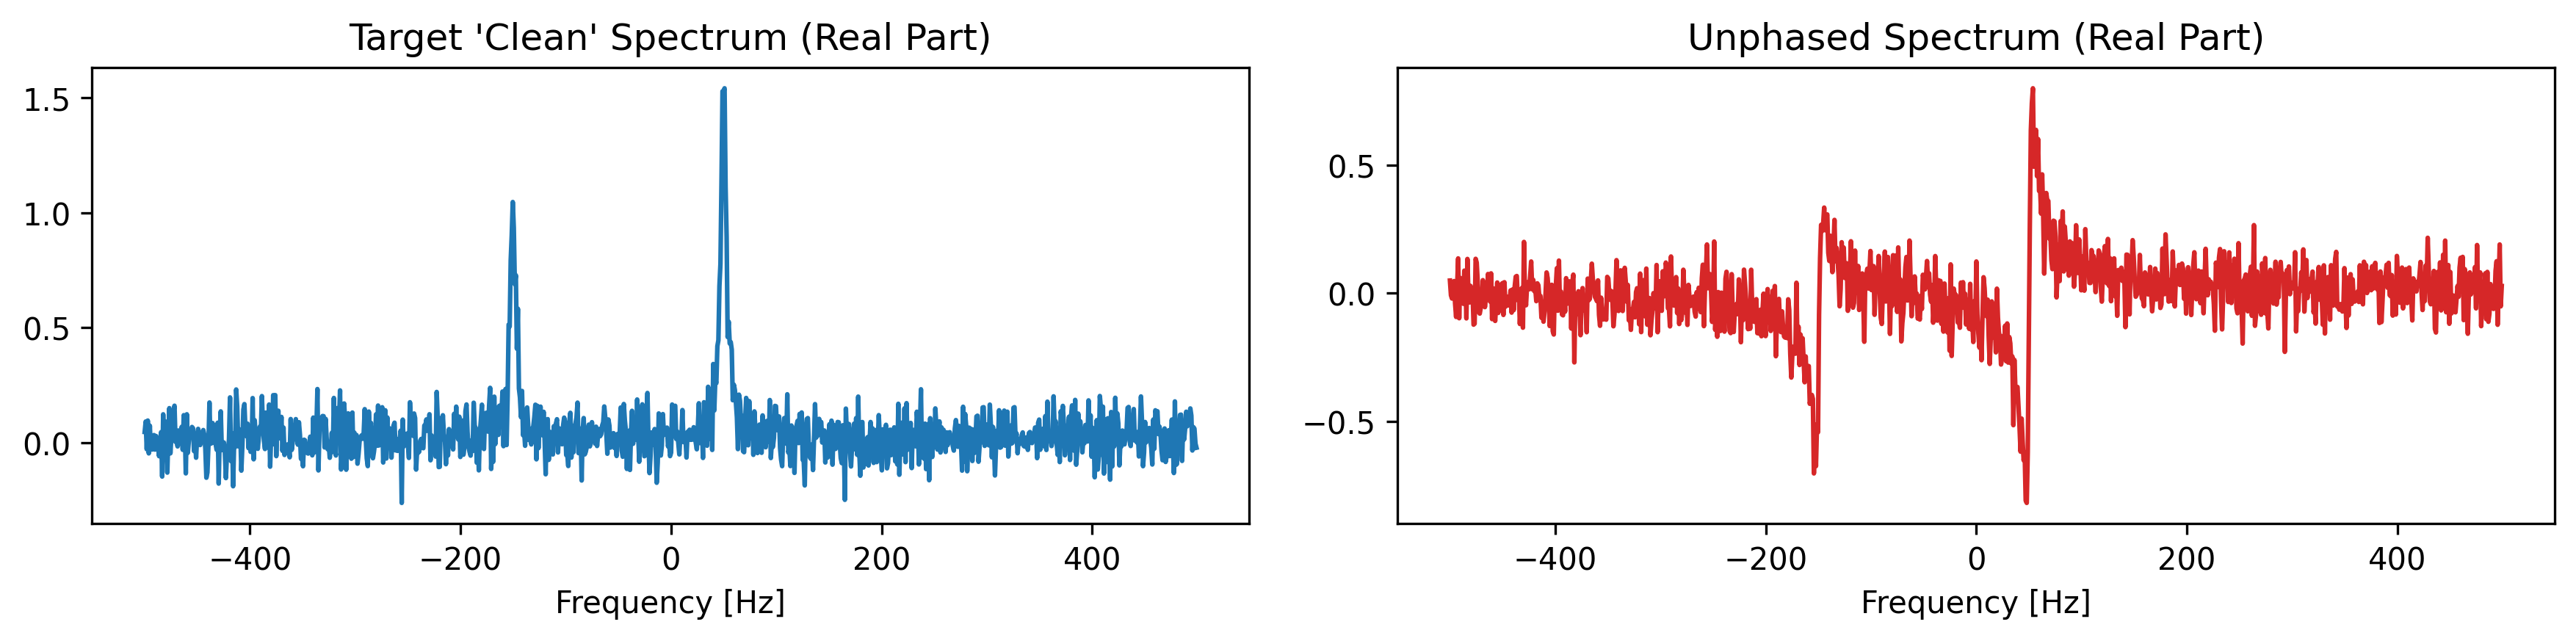

In [3]:
# Acquisition parameters
dwell_time = 0.001  # 1 ms
n_points = 1024
t = np.arange(n_points) * dwell_time

# Synthetic FID: Two peaks at 50 Hz and -150 Hz
rng = np.random.default_rng(42)
clean_fid = np.exp(-t / 0.05) * (
    np.exp(1j * 2 * np.pi * 50 * t) + 0.6 * np.exp(1j * 2 * np.pi * -150 * t)
)
noise = rng.normal(scale=0.08, size=n_points) + 1j * rng.normal(scale=0.08, size=n_points)
raw_fid = clean_fid + noise

# Xarray construction and FFT
da_fid = xr.DataArray(
    raw_fid, dims=["time"], coords={"time": t}, attrs={"sequence": "sLASER", "B0": 7.0}
)
da_spec = da_fid.xmr.to_spectrum()

# Intentionally ruin the phase: p0 = 120 degrees, p1 = -45 degrees
da_ruined = da_spec.xmr.phase(p0=120.0, p1=-45.0)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
da_spec.real.plot(ax=axes[0], color="tab:blue")
axes[0].set_title("Target 'Clean' Spectrum (Real Part)")

da_ruined.real.plot(ax=axes[1], color="tab:red")
axes[1].set_title("Unphased Spectrum (Real Part)")
plt.tight_layout()
plt.show()

## 2. Manual Phase Correction

We can manually apply zero- and first-order phase correction (in degrees) using the `.xmr.phase()` method.
Because this is an `xarray` accessor, the exact quantifiable phase angles used are permanently appended to the
`DataArray` attributes (as `phase_p0` and `phase_p1`) to safely preserve the data lineage.

Since we know we ruined the spectrum with $p_0 = 120^\circ$ and $p_1 = -45^\circ$, we can restore it
by applying the exact inverse.

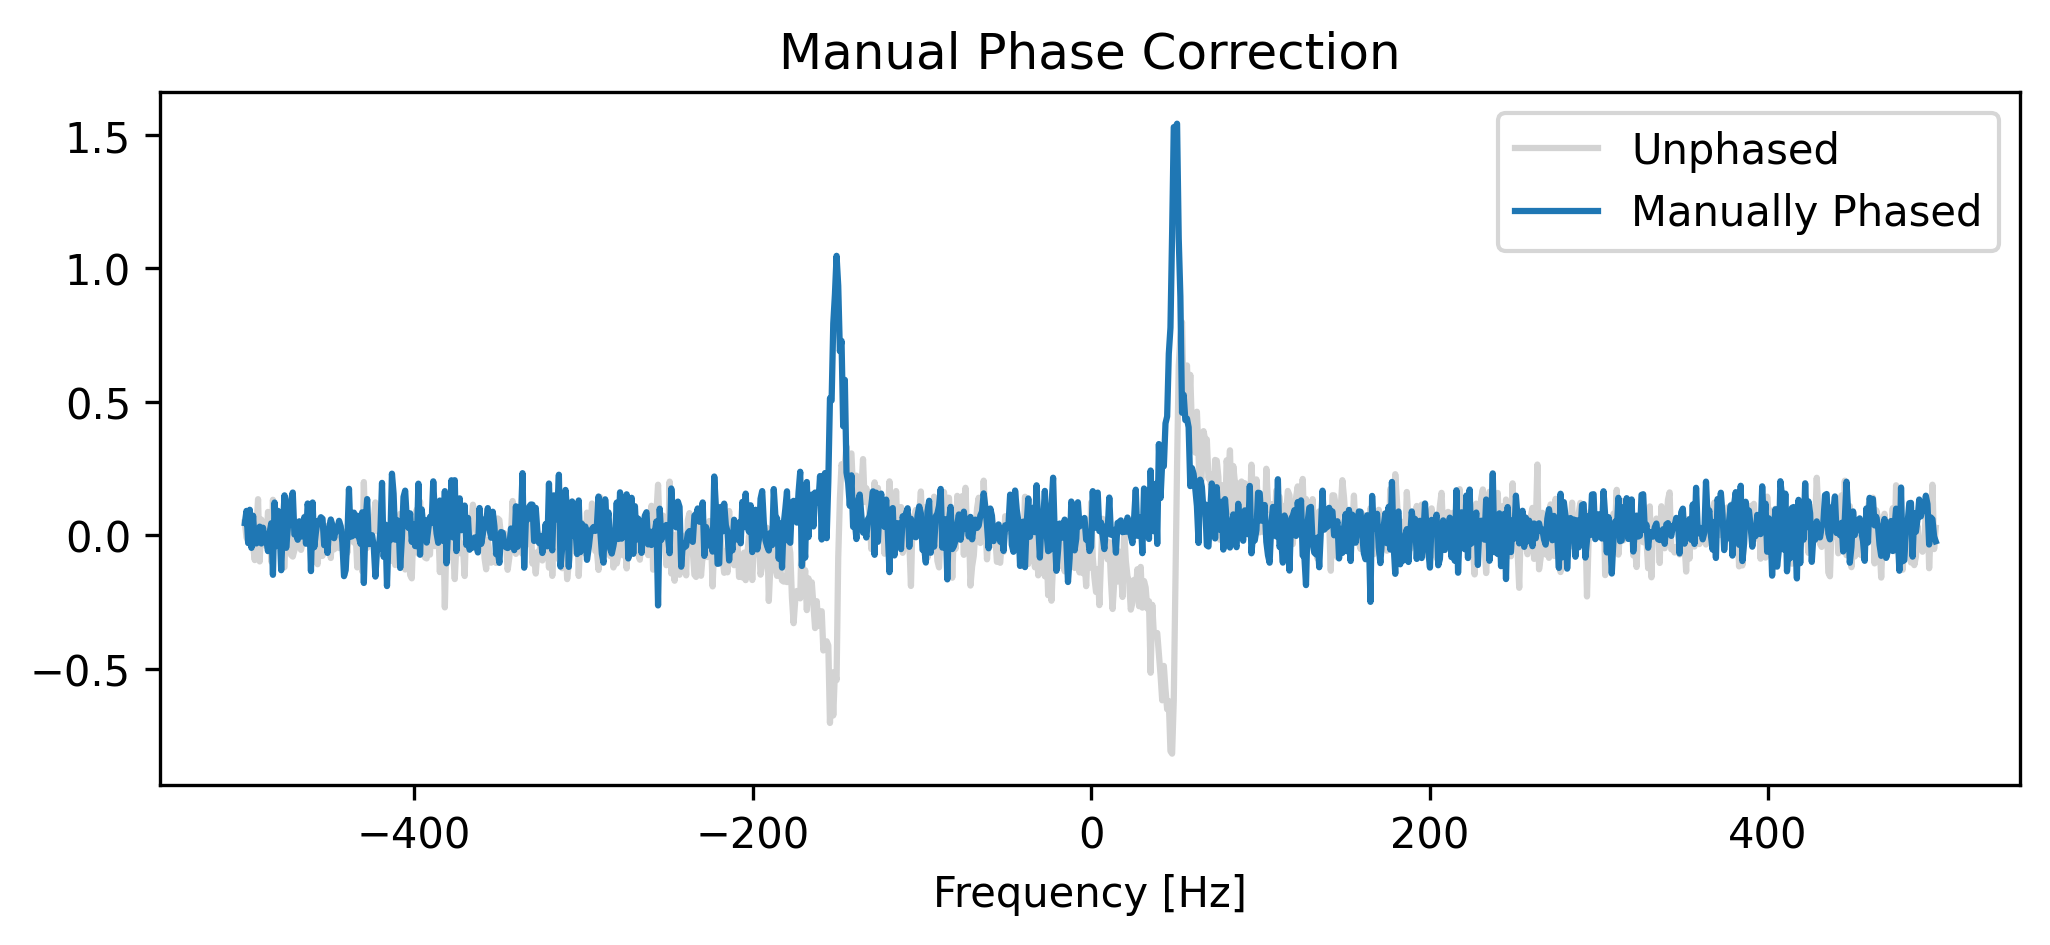

Stored Phase Attributes:
  phase_p0: -120.0
  phase_p1: 45.0


In [4]:
# Apply the inverse phase angles and specify the dimension
da_manual = da_ruined.xmr.phase(dim="frequency", p0=-120.0, p1=45.0)

fig, ax = plt.subplots(figsize=(8, 3))
da_ruined.real.plot(ax=ax, color="lightgray", label="Unphased")
da_manual.real.plot(ax=ax, color="tab:blue", label="Manually Phased")
plt.legend()
plt.title("Manual Phase Correction")
plt.show()

# Print the attributes to see the strictly tracked mathematical lineage
print("Stored Phase Attributes:")
print(f"  phase_p0: {da_manual.attrs.get('phase_p0')}")
print(f"  phase_p1: {da_manual.attrs.get('phase_p1')}")


:::{dropdown} Under the Hood: No Magic Strings
As a user, you can pass simple strings like `"frequency"` to `xmris` functions. However, internally, the package never uses raw strings. It maps your input to a strict global vocabulary (`xmris.core.config.DIMS` and `COORDS`).

This architecture allows `xmris` to intercept your request and automatically validate that the operation is physically possible for the given dimensions!
:::

In [5]:
# STRICT TESTS: Manual Phase Correction
assert "phase_p0" in da_manual.attrs and "phase_p1" in da_manual.attrs
assert da_manual.attrs["phase_p0"] == -120.0
assert da_manual.attrs["phase_p1"] == 45.0

# Prove metadata preservation
assert da_manual.dims == da_ruined.dims, "Dimensions altered."
np.testing.assert_array_equal(
    da_manual.coords["frequency"].values,
    da_ruined.coords["frequency"].values,
    err_msg="Coords altered.",
)
assert da_manual.attrs["sequence"] == "sLASER", "Original attributes dropped."

# Prove exact mathematical recovery (allowing for small floating point drift)
np.testing.assert_allclose(
    da_manual.values,
    da_spec.values,
    rtol=1e-5,
    atol=1e-5,
    err_msg="Manual phase math failed to invert.",
)

## 3. Automated Phase Correction (`autophase`)

Finding the perfect phase angles manually is tedious. We can use an entropy-minimization
algorithm (ACME) to find the global phase minimum automatically.

However, ACME struggles with high noise floors. The `autophase()` method solves this by
executing a hidden "sacrificial apodization" step:

1. It temporarily inverse-transforms the spectrum back to the time domain.
2. It applies severe exponential line broadening (`lb`) to crush the noise.
3. It transforms the smoothed data back to the frequency domain.
4. It runs the ACME algorithm on the smoothed data to accurately determine $p_0$ and $p_1$.
5. It applies those angles to the **original, high-resolution** input spectrum.

Optimization terminated successfully.
         Current function value: 0.011556
         Iterations: 110
         Function evaluations: 209


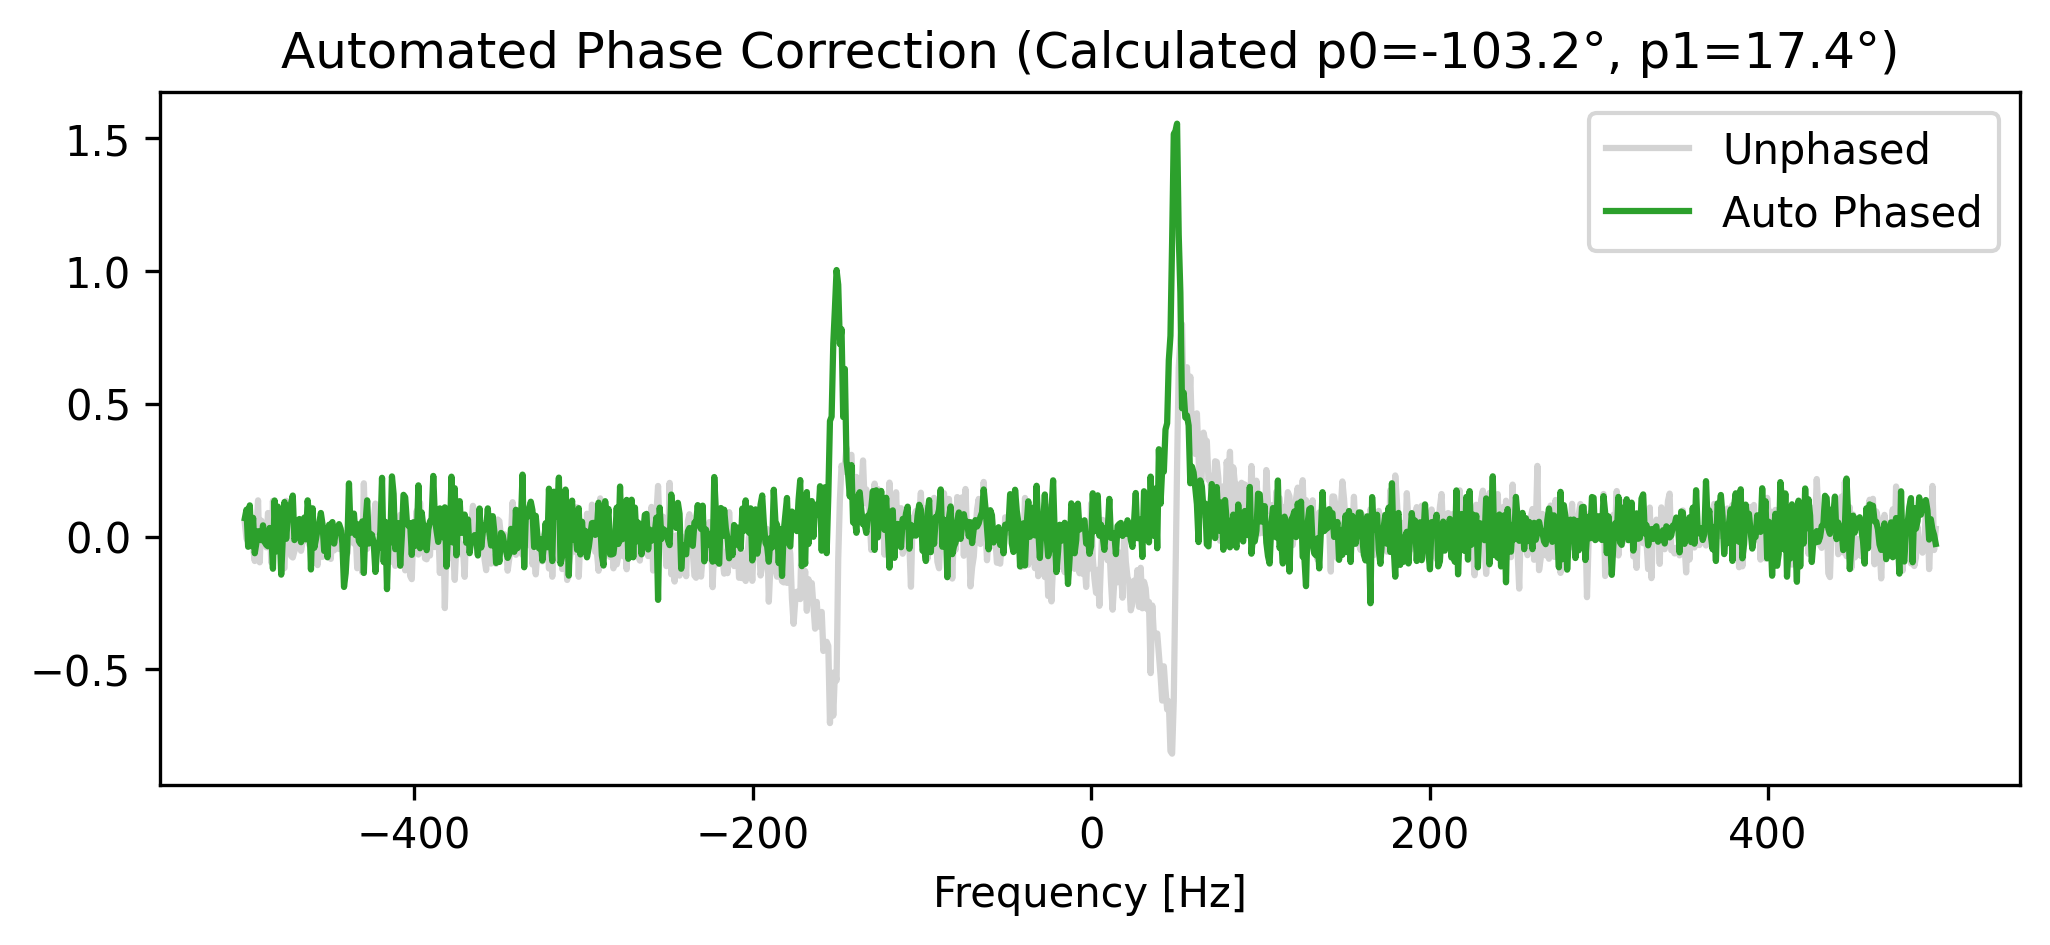

In [6]:
# Apply autophase. A line broadening of 15 Hz is used purely for the
# hidden optimizer calculation to suppress the noise.
da_auto = da_ruined.xmr.autophase(dim="frequency", lb=15.0)

fig, ax = plt.subplots(figsize=(8, 3))
da_ruined.real.plot(ax=ax, color="lightgray", label="Unphased")
da_auto.real.plot(ax=ax, color="tab:green", label="Auto Phased")
plt.legend()
plt.title(
    f"Automated Phase Correction (Calculated p0={da_auto.attrs['phase_p0']:.1f}°, p1={da_auto.attrs['phase_p1']:.1f}°)"
)
plt.show()


In [7]:
# STRICT TESTS: Automated Phase Correction
assert "phase_p0" in da_auto.attrs and "phase_p1" in da_auto.attrs

# Prove metadata preservation
assert da_auto.dims == da_ruined.dims, "Dimensions altered by the IFFT/FFT roundtrip."
np.testing.assert_array_equal(
    da_auto.coords["frequency"].values,
    da_ruined.coords["frequency"].values,
    err_msg="Coords altered by the IFFT/FFT roundtrip.",
)
assert da_auto.attrs["sequence"] == "sLASER", "Original attributes dropped."

# Prove autophase did not alter the fundamental unphased magnitude (ensuring the
# sacrificial LB wasn't accidentally applied to the final output)
np.testing.assert_allclose(
    np.abs(da_auto.values),
    np.abs(da_ruined.values),
    rtol=1e-5,
    atol=1e-5,
    err_msg="Autophase altered the absolute magnitude of the spectrum.",
)

```